# Were there trends in terms of job-posting count or most demanded skills throughout 2023?

## Data loading

In [94]:
import os
import ast 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from matplotlib.ticker import PercentFormatter

def rename_months(x: pd.DataFrame) -> pd.DataFrame:
    """
    Convert the month numbers into month names (for plotting).
    """
    # Convert, e.g., 1 to Jan, 8 to Aug
    convert_month = lambda x: pd.to_datetime(x, format='%m').strftime('%b')

    x = x.reset_index()
    x['job_posted_month'] = x['job_posted_month'].apply(convert_month)
    return x.set_index('job_posted_month')


# Load data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Drop duplicates
df = df.drop_duplicates()

# Convert date to datetime
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Convert df['job_skills'] from a string to a list of strings
convert_skills = lambda x: ast.literal_eval(x) if pd.notna(x) else x
df['job_skills'] = df['job_skills'].apply(convert_skills)

# Output directory for graphs
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

In [95]:
# Time period covered by the dataset (corresponds to 2023)
df['job_posted_date'].agg(['min', 'max'])

min   2023-01-01 00:00:04
max   2023-12-31 23:59:58
Name: job_posted_date, dtype: datetime64[ns]

## Monthly trends in 2023

Here, we take data-analyst job postings as an example.

In [96]:
# Pre-filter based on job_title_short
job_title = 'Data Analyst'
df_relevant = df[df['job_title_short'] == job_title].copy()

# Extract month from date
df_relevant['job_posted_month'] = df_relevant['job_posted_date'].dt.month

# Compute job count per month
df_job_month = df_relevant.groupby('job_posted_month').size()

# Explode skills (which are initially contained in lists within 'job_skills')
df_skills_count = df_relevant.explode('job_skills')

# Pivot to group by month and job_skills
df_skills_count = df_skills_count.pivot_table(
    index='job_posted_month',
    columns='job_skills',
    aggfunc='size',
    fill_value=0  # In case certain skills are not requested a specific month 
)

# Sort by count
df_skills_count.loc['count'] = df_skills_count.sum()
df_skills_count = df_skills_count.sort_values('count', axis=1, ascending=False)
df_skills_count = df_skills_count.drop('count')

# Compute job counts per month
job_count = df_relevant.groupby('job_posted_month').size()

# Divide the previous skill counts by the job counts to get the likelihoods
df_skills_likelihood = 100*df_skills_count.div(job_count, axis=0)

# Rename months
df_job_month = rename_months(df_job_month)
df_skills_likelihood = rename_months(df_skills_likelihood)

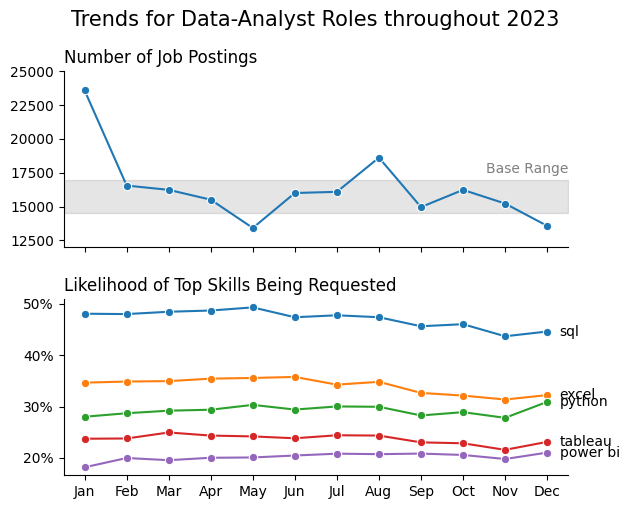

In [97]:
n_skills = 5
job_title_plot = job_title.replace(' ', '-')
job_title_filename = job_title.lower().replace(' ', '_')

fig, ax = plt.subplots(2, 1)

# Plot job count
df_plot = df_job_month
sns.lineplot(df_plot, dashes=False, marker='o', ax=ax[0], legend=False)
sns.despine()
ax[0].set_title('Number of Job Postings', loc='left')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels('')
ax[0].set_xlim([-0.5, 11.5])
ax[0].set_ylim([12000, 25000])

# Color ad-hoc range to highlight months with few/numerous job postings
ax[0].fill_between(x=[-0.5, 11.5],
                   y1=[14500, 14500],
                   y2=[17000, 17000],
                   color='k',
                   alpha=0.1)
ax[0].text(11.5, 17300, 'Base Range', va='bottom', ha='right', color='grey')

# Plot likelihood
df_plot = df_skills_likelihood.iloc[:, :n_skills]
sns.lineplot(df_plot, dashes=False, marker='o', ax=ax[1], legend=False)
sns.despine()
ax[1].set_title('Likelihood of Top Skills Being Requested', loc='left')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].yaxis.set_major_formatter(PercentFormatter(decimals=0))
for i, v in enumerate(df_plot.columns):
    ax[1].text(11.3, df_plot.iloc[-1, i], v,
               color='black', va='center')

plt.tight_layout(h_pad=1.8)
plt.suptitle(f'Trends for {job_title_plot} Roles throughout 2023',y=1.05, fontsize=15)

plt.savefig(os.path.join(output_directory, '3_monthly_trends_' + job_title_filename + '.png'),
            bbox_inches='tight', dpi=600)
plt.show()

An ad-hoc base range was added in the top graph to highlight months with few/numerous job postings, whose job counts are outside this range.

**Breakdown:**
- (Top) Most data-analyst jobs were posted in January 2023.
- (Top) There was a resurgence in data-analyst job postings in August 2023.
- (Top) Among the remaining months, May and December 2023 showed fewer data-analyst job postings.
- (Bottom) While the number of job postings was previously shown to be quite time-dependent, the likelihood of top skills being requested in data-analyst job postings was rather constant throughout 2023.

Importantly, the number of job postings and skill likelihood behave similarly for other main data roles. This indicates that while the number of job postings fluctuated during 2023, the skill expectations for main data roles remained the same throughout the year.